## MODELOS ARIMA & LSTM PARA PRONÓSTICO DE DEMANDA DE GAS NATURAL EN SECTOR PETROLERO EN MÉXICO
## UNAM
## Alumno: Ibarra Ramírez Sergio

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from sympy import true
from datetime import datetime, timedelta
register_matplotlib_converters()
from time import time 

Importamos la data de Demanda de gas en sector petrolero como un CSV

Se lee la data "original" de Demanda en sector petrolero

In [3]:
demanda_petrolero_original = pd.read_csv('Demanda_petrolero_2023.csv',index_col='Date',parse_dates=True)
demanda_petrolero_original

,Demanded_Gas
Date,
2005-01-01,2039.875
2005-02-01,2015.255
2005-03-01,1969.507
2005-04-01,2008.187
2005-05-01,2041.864
...,...
2023-05-01,1663.904
2023-06-01,1671.033
2023-07-01,1375.367


Se grafica la data "original" de Demanda en sector petrolero

Text(0, 0.5, 'Demanda [MMpcd]')

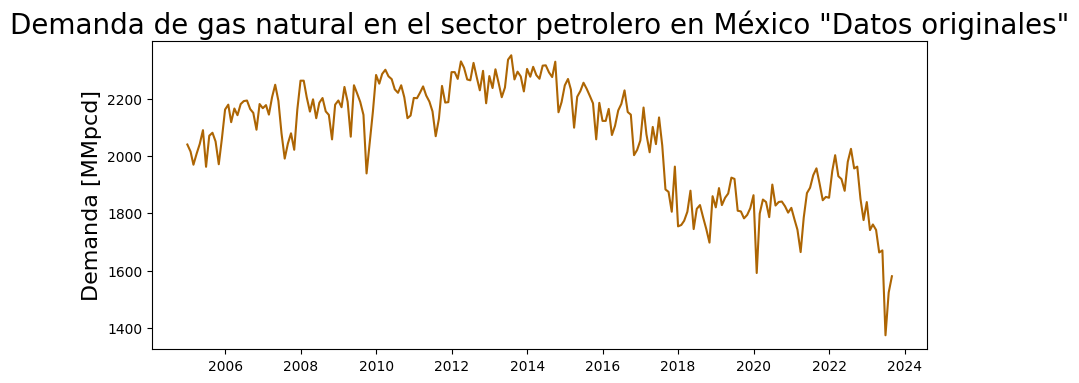

In [4]:
plt.figure(figsize=(10,4))
plt.plot(demanda_petrolero_original, color='#AD6503')
plt.title('Demanda de gas natural en el sector petrolero en México "Datos originales"', fontsize=20)
plt.ylabel('Demanda [MMpcd]', fontsize =16)

Se descompone la data "original" de Demanda en sector eléctrico en sus compoentes de Tendencia, Estacionalidad y Residual

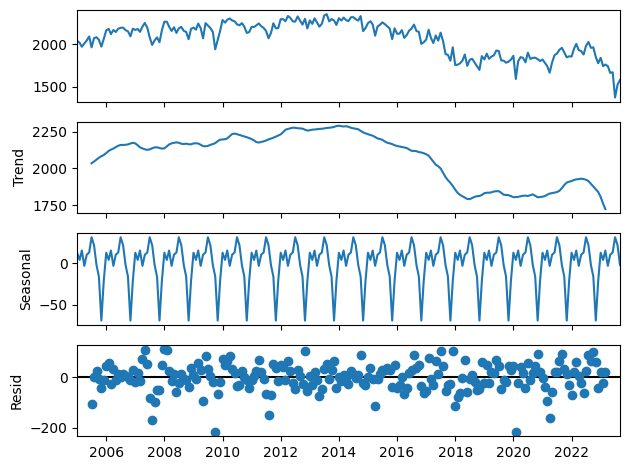

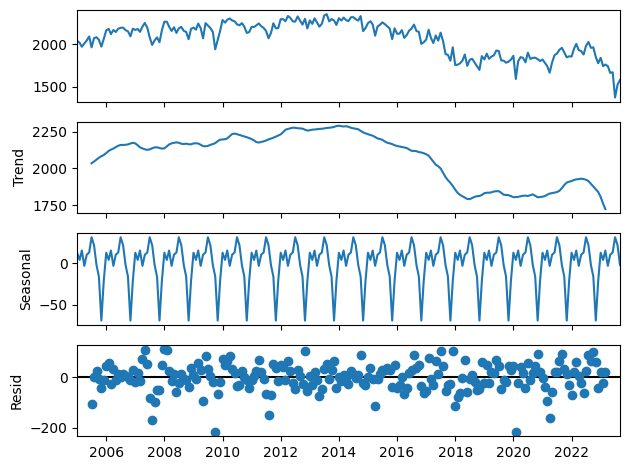

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose

demanda_petrolero_original_seasonal_decomposition = seasonal_decompose(demanda_petrolero_original)
demanda_petrolero_original_seasonal_decomposition.plot()

Separamos la data original de Demanda de gas natural en el sector petrolero en data de train y test

In [6]:
# Number of data points to keep for testing (in this case, the last 12)
num_test_points = 12

# Split the data into training and testing sets
demanda_petrolero_original_train_data = demanda_petrolero_original[:-num_test_points]
demanda_petrolero_original_test_data = demanda_petrolero_original[-num_test_points:]

demanda_petrolero_original_train_data

,Demanded_Gas
Date,
2005-01-01,2039.875
2005-02-01,2015.255
2005-03-01,1969.507
2005-04-01,2008.187
2005-05-01,2041.864
...,...
2022-05-01,1919.429
2022-06-01,1878.572
2022-07-01,1979.696


Se grafica la distribución de los datos "originales" de train de Demanda en sector petrolero

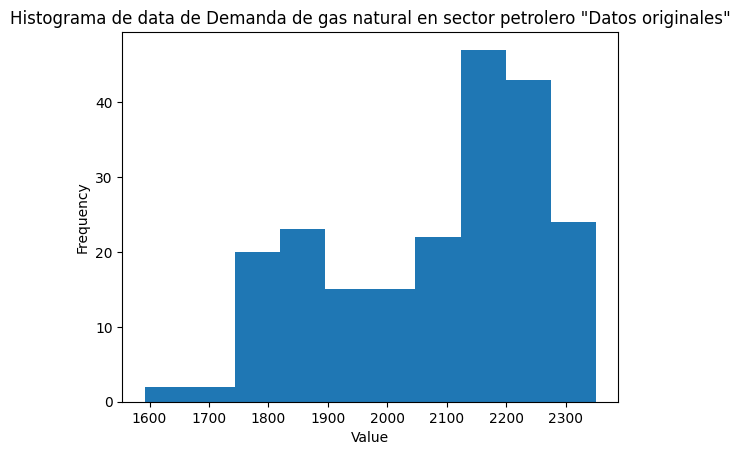

In [7]:
# Generate the histogram
plt.hist(demanda_petrolero_original_train_data, bins=10)  # Adjust the number of bins as per your data

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histograma de data de Demanda de gas natural en sector petrolero "Datos originales"')

# Display the plot
plt.show()

In [8]:
demanda_petrolero_original_train_data.describe()

,Demanded_Gas
count,213.000000
mean,2082.555484
std,176.114805
min,1592.280000
25%,1933.018000
50%,2143.112000
75%,2224.715000
max,2350.709000


In [9]:
mean_demanda_petrolero_original_train_data =  demanda_petrolero_original_train_data.describe().values[1]
mean_demanda_petrolero_original_train_data

array([2082.55548357])

In [10]:
st_demanda_petrolero_original_train_data =  demanda_petrolero_original_train_data.describe().values[2]
st_demanda_petrolero_original_train_data

array([176.11480537])

In [11]:
mean_demanda_petrolero_original_train_data / st_demanda_petrolero_original_train_data

array([11.82498813])

Se lleva a cabo una prueba de normalidad a los datos "originales escalados" de train de Demanda en sector petrolero

In [8]:
import scipy.stats as stats

# Assuming demanda_electrico_original_train_data is a pandas Series or DataFrame
# You can access the values as follows:
data = demanda_petrolero_original_train_data

# Perform the Jarque-Bera test
jb_statistic, jb_p_value = stats.jarque_bera(data)

# Check the p-value to determine whether the data follows a normal distribution
alpha = 0.05  # Significance level
if jb_p_value < alpha:
    print(f"La data NO sigue una distribución normal")
else:
    print("La data SI sigue una distribución normal")

# Optionally, you can also print the JB statistic and p-value
print("Jarque-Bera Statistic:", jb_statistic)
print("p-value:", jb_p_value)

La data NO sigue una distribución normal
Jarque-Bera Statistic: 18.08888224642761
p-value: 0.00011804541635138615


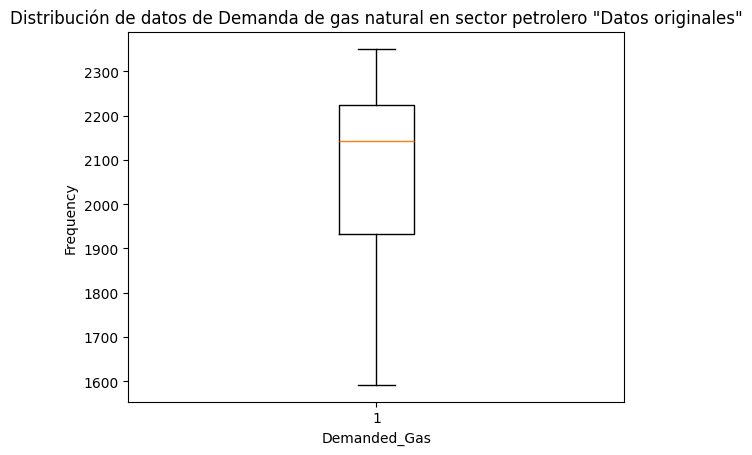

In [9]:
# Create a boxplot of the Demanded_Gas column
plt.boxplot(demanda_petrolero_original_train_data)

# Add labels and title
plt.xlabel('Demanded_Gas')
plt.ylabel('Frequency')
plt.title('Distribución de datos de Demanda de gas natural en sector petrolero "Datos originales"')

# Display the plot
plt.show()

Se generan sets de n_input datos para con ellos predecir el t+1 dato, y así los siguientes n_input para predecir el t+1, etc

In [10]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [11]:
demanda_petrolero_original_train_data["Demanded_Gas"]

Date
2005-01-01    2039.875
2005-02-01    2015.255
2005-03-01    1969.507
2005-04-01    2008.187
2005-05-01    2041.864
                ...   
2022-05-01    1919.429
2022-06-01    1878.572
2022-07-01    1979.696
2022-08-01    2024.823
2022-09-01    1956.582
Name: Demanded_Gas, Length: 213, dtype: float64

In [12]:
n_input = 12

data = demanda_petrolero_original_train_data["Demanded_Gas"]
targets = data 


demanda_petrolero_original_train_generator = TimeseriesGenerator(data, targets, length=n_input, batch_size=1)

In [13]:
print("Total number of samples in the original training data = ", len(demanda_petrolero_original_train_data)) 
print("Total number of samples in the demanda_petrolero_train_generator = ", len(demanda_petrolero_original_train_generator))


Total number of samples in the original training data =  213
Total number of samples in the demanda_petrolero_train_generator =  201


In [14]:
demanda_petrolero_original_train_generator[200]

c:\Users\llell\OneDrive\Documentos\MIS\MIS_tesis_follow_full_Desktop_Dell\TESIS_GIT_Desktop_Dell\MIS_Tesis_Venv1\Lib\site-packages\keras\src\legacy\preprocessing\sequence.py:120: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  targets = np.array([self.targets[row] for row in rows])


(array([[1956.838, 1904.215, 1845.705, 1857.401, 1854.424, 1947.411,
         2002.632, 1929.43 , 1919.429, 1878.572, 1979.696, 2024.823]]),
 array([1956.582]))

### Se define y entrena la red neuronal FNN  para el caso de la data original de Demanda en el sector petrolero

In [15]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [16]:
seed_value=2024

import numpy as np
np.random.seed(seed_value)


import tensorflow as tf
tf.random.set_seed(seed_value)

# Set a seed for numpy random number generation
np.random.seed(0)

# Set a seed for TensorFlow random number generation
tf.random.set_seed(0)

Se define la red neuronal FFNN con capas densas y funcion de activación tipo RELU.

In [17]:
n_input = 12
n_features = 1

# define model
model_FF_petrolero_sin_tratamiento = Sequential()
model_FF_petrolero_sin_tratamiento.add(Dense(64, activation='relu', input_shape=(n_input, n_features)))
model_FF_petrolero_sin_tratamiento.add(Dense(32, activation='relu'))
model_FF_petrolero_sin_tratamiento.add(Dense(1))
model_FF_petrolero_sin_tratamiento.compile(optimizer='Adam', loss='mse')

c:\Users\llell\OneDrive\Documentos\MIS\MIS_tesis_follow_full_Desktop_Dell\TESIS_GIT_Desktop_Dell\MIS_Tesis_Venv1\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [18]:
model_FF_petrolero_sin_tratamiento.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 12, 64)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 12, 32)         │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 12, 1)          │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,241 (8.75 KB)

 Trainable params: 2,241 (8.75 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
model_FF_petrolero_sin_tratamiento.fit(demanda_petrolero_original_train_generator, epochs=12)

Epoch 1/12


 69/201 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2903924.7500

c:\Users\llell\OneDrive\Documentos\MIS\MIS_tesis_follow_full_Desktop_Dell\TESIS_GIT_Desktop_Dell\MIS_Tesis_Venv1\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


201/201 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 1572078.5000
Epoch 2/12
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 10604.3379
Epoch 3/12
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 12019.9619
Epoch 4/12
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 12563.4932
Epoch 5/12
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 11426.8486
Epoch 6/12
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 13085.8623
Epoch 7/12
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 11734.4814
Epoch 8/12
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 12581.6875
Epoch 9/12
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 12186.3721
Epoch 10/12
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 11863.2959
Epoch 11/12
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 14231.2852
Epoch 12/12
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 12525.7119


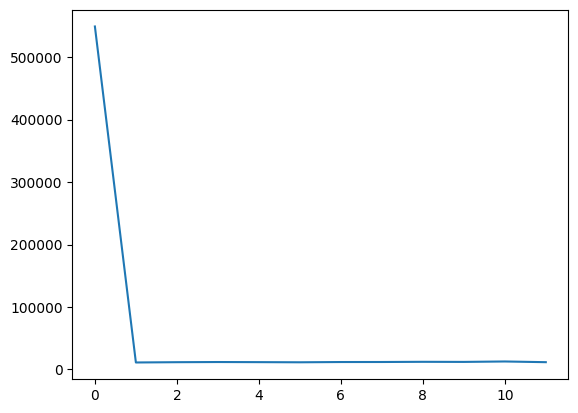

In [20]:
loss_per_epoch_model_FF = model_FF_petrolero_sin_tratamiento.history.history['loss']
plt.plot(range(len(loss_per_epoch_model_FF)),loss_per_epoch_model_FF)

Se lleva a cabo el forecast de los ultimos 12 meses usando el modelo model_sequential_and_FF previamente definido y entrenado

Ahora ser hará una función que irá formando batch de n_input para ir prediciendo el siguiente valor, tal como se hizo en el entrenamiento del modelo

In [21]:
n_input = 12
n_features = 1

In [22]:
test_predictions_model_FF_petrolero_sin_pretratamiento = []

first_eval_batch = demanda_petrolero_original_train_data['Demanded_Gas'].values[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(demanda_petrolero_original_test_data['Demanded_Gas'])):
    
    # get the prediction value for the first batch
    current_pred = model_FF_petrolero_sin_tratamiento.predict(current_batch)[0][-1][0]
    
    # append the prediction into the array
    test_predictions_model_FF_petrolero_sin_pretratamiento.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[[current_pred]]],axis=1)
    current_batch = current_batch.reshape((1, n_input, n_features))  # Reshape to maintain the 3D shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


In [23]:
test_predictions_model_FF_petrolero_sin_pretratamiento

[1947.8394,
 1939.1385,
 1930.4794,
 1921.8616,
 1913.2852,
 1904.7496,
 1896.2551,
 1887.8013,
 1879.3877,
 1871.0148,
 1862.6818,
 1854.3885]

Text(0, 0.5, 'Demanda [MMpcd]')

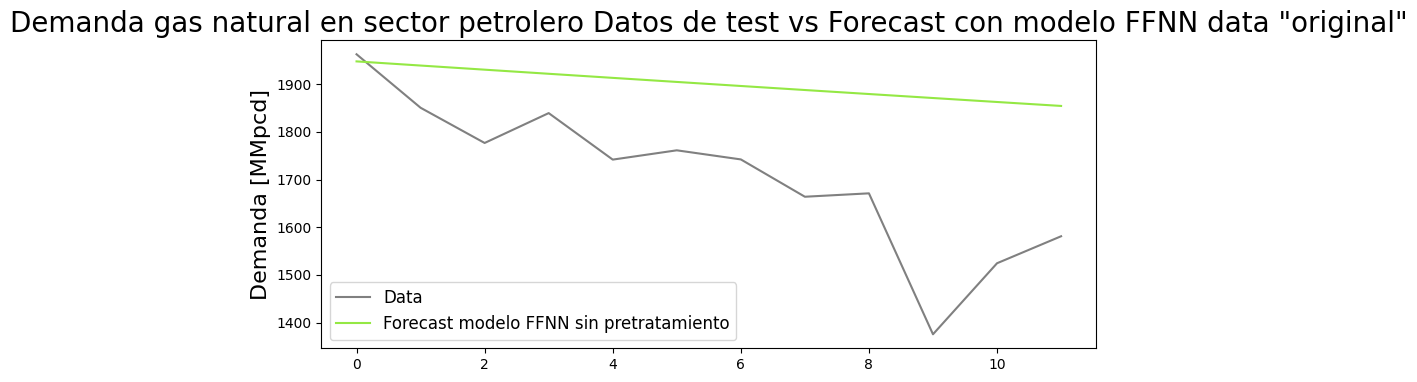

In [24]:
##Ploting the predicitons vs the test_data
plt.figure(figsize =(10,4))
plt.plot(demanda_petrolero_original_test_data['Demanded_Gas'].values, color='gray')
plt.plot(test_predictions_model_FF_petrolero_sin_pretratamiento, color='#94E844')
plt.legend(('Data', 'Forecast modelo FFNN sin pretratamiento'), fontsize=12)

plt.title('Demanda gas natural en sector petrolero Datos de test vs Forecast con modelo FFNN data "original"', fontsize=20)
plt.ylabel('Demanda [MMpcd]', fontsize=16)

### Se define y entrena la red neuronal LSTM  para el caso de la data original de Demanda en el sector petrolero

Se usa una semilla para intentar homologar los valores iniciales de pesos y bias  

In [25]:
seed_value=2024

import numpy as np
np.random.seed(seed_value)


import tensorflow as tf
tf.random.set_seed(seed_value)

# Set a seed for numpy random number generation
np.random.seed(0)

# Set a seed for TensorFlow random number generation
tf.random.set_seed(0)

Se define la red neuronal LSMT con capas densas y funcion de activación tipo RELU.

In [26]:
n_input = 12
n_features = 1

In [27]:


# define model
model_LSTM_petrolero_original = Sequential()
model_LSTM_petrolero_original.add(LSTM(50, activation='relu', input_shape=(n_input, n_features)))
model_LSTM_petrolero_original.add(Dense(1))
model_LSTM_petrolero_original.compile(optimizer='adam', loss='mse')

c:\Users\llell\OneDrive\Documentos\MIS\MIS_tesis_follow_full_Desktop_Dell\TESIS_GIT_Desktop_Dell\MIS_Tesis_Venv1\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [28]:
model_LSTM_petrolero_original.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

Entrenamos el modelo LSTM

In [29]:
model_LSTM_petrolero_original.fit(demanda_petrolero_original_train_generator, epochs=12)


Epoch 1/12


201/201 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 2414458.7500
Epoch 2/12
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5753.7925
Epoch 3/12
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 8247.1104
Epoch 4/12
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7028.2183
Epoch 5/12
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 8714.9961
Epoch 6/12
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 8179.9395
Epoch 7/12
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5857.1665
Epoch 8/12
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 8085.3906
Epoch 9/12
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 8589.9043
Epoch 10/12
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7589.8496
Epoch 11/12
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7910.4888
Epoch 12/12
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9417.7441


Se grafica la perdida por epoch

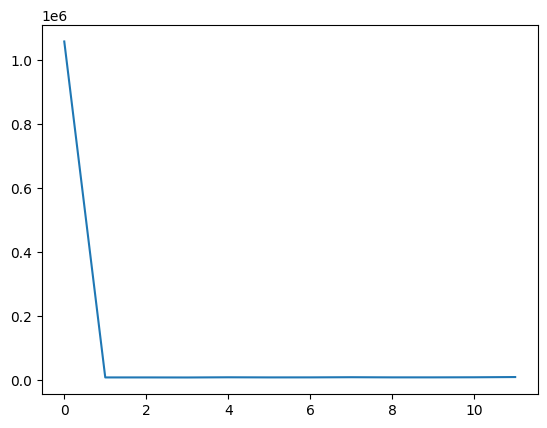

In [30]:
loss_per_epoch_model_FF = model_LSTM_petrolero_original.history.history['loss']
plt.plot(range(len(loss_per_epoch_model_FF)),loss_per_epoch_model_FF)

### Se lleva a cabo el forecast de los ultimos 12 meses usando el modelo model_LSTM_petrolero_original previamente definido y entrenado

#### Ahora ser hará una función que irá formando batch de n_input para ir prediciendo el siguiente valor, tal como se hizo en el entrenamiento del modelo

In [31]:
n_input = n_input
n_features = n_features

In [32]:
test_predictions_model_LSTM_petrolero_original = []

first_eval_batch = demanda_petrolero_original_train_data[-n_input:]["Demanded_Gas"].values
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(demanda_petrolero_original_test_data)):
    
    # get the prediction value for the first batch
    current_pred = model_LSTM_petrolero_original.predict(current_batch)[0]

    print("Current_batch is:")
    print(current_batch)
    print("************************************************************************")
    print("Current_pred is:")
    print(current_pred)
    # append the prediction into the array
    test_predictions_model_LSTM_petrolero_original.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
    current_batch = current_batch.reshape((1, n_input, n_features))  # Reshape to maintain the 3D shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
Current_batch is:
[[[1904.215]
  [1845.705]
  [1857.401]
  [1854.424]
  [1947.411]
  [2002.632]
  [1929.43 ]
  [1919.429]
  [1878.572]
  [1979.696]
  [2024.823]
  [1956.582]]]
************************************************************************
Current_pred is:
[1922.0022]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Current_batch is:
[[[1845.705     ]
  [1857.401     ]
  [1854.424     ]
  [1947.411     ]
  [2002.632     ]
  [1929.43      ]
  [1919.429     ]
  [1878.572     ]
  [1979.696     ]
  [2024.823     ]
  [1956.582     ]
  [1922.00219727]]]
************************************************************************
Current_pred is:
[1919.8676]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Current_batch is:
[[[1857.401     ]
  [1854.424     ]
  [1947.411     ]
  [2002.632     ]
  [1929.43      ]
  [1919.429     ]
  [1878.572     ]
  [1979.696     ]
  [2024.823     ]
  [1956.582     ]
  [1922.00219727]
  [1919.86755371]]]
*********************************

In [33]:
test_predictions_model_LSTM_petrolero_original

[array([1922.0022], dtype=float32),
 array([1919.8676], dtype=float32),
 array([1930.8292], dtype=float32),
 array([1945.0975], dtype=float32),
 array([1951.0586], dtype=float32),
 array([1951.5321], dtype=float32),
 array([1941.03], dtype=float32),
 array([1942.9834], dtype=float32),
 array([1950.3622], dtype=float32),
 array([1956.8439], dtype=float32),
 array([1953.594], dtype=float32),
 array([1945.182], dtype=float32)]

Se grafican los 12 meses de test vs el forecast del modelo LSTM con la data de entrenamiento 

Text(0, 0.5, 'Demanda [MMpcd]')

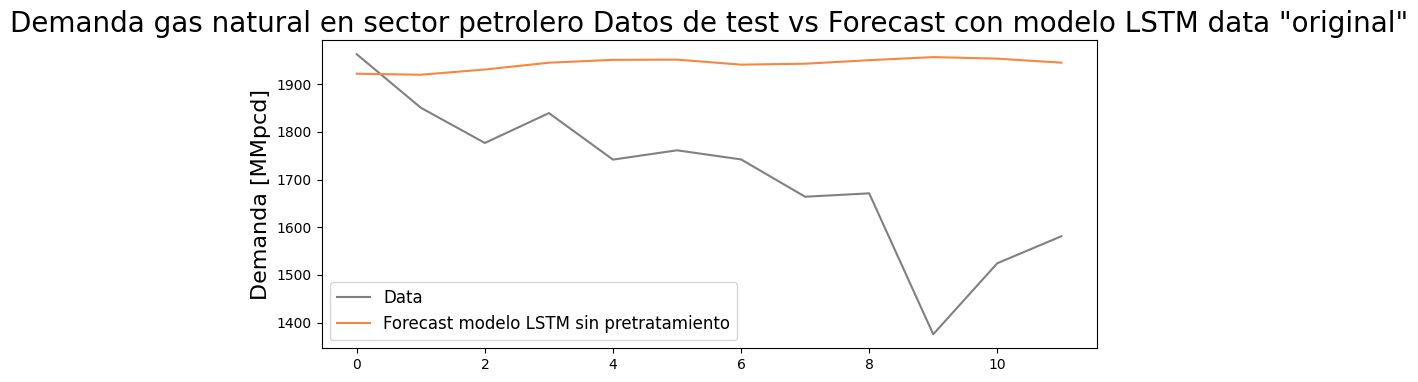

In [34]:
##Ploting the predicitons vs the test_data
plt.figure(figsize =(10,4))
plt.plot(demanda_petrolero_original_test_data['Demanded_Gas'].values, color='gray')
plt.plot(test_predictions_model_LSTM_petrolero_original, color='#F8873E')
plt.legend(('Data', 'Forecast modelo LSTM sin pretratamiento'), fontsize=12)

plt.title('Demanda gas natural en sector petrolero Datos de test vs Forecast con modelo LSTM data "original"', fontsize=20)
plt.ylabel('Demanda [MMpcd]', fontsize=16)

Se calcula el error de pronóstico para los 12 meses de test con  modelo LSTM sin la data pretratada

In [35]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import numpy as np

# Compute errors
MAPE_predictions_model_LSTM_petrolero_original = mean_absolute_percentage_error(demanda_petrolero_original_test_data['Demanded_Gas'].values, test_predictions_model_LSTM_petrolero_original)
RMSE_predictions_model_LSTM_petrolero_original = np.sqrt(mean_squared_error(demanda_petrolero_original_test_data['Demanded_Gas'].values, test_predictions_model_LSTM_petrolero_original))

print('MAPE:', MAPE_predictions_model_LSTM_petrolero_original)
print('RMSE:', RMSE_predictions_model_LSTM_petrolero_original)

MAPE: 0.15119173742652567
RMSE: 284.57387406507917


Se verifica la estacionariedad de la data original 

In [36]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller

# Perform ADF test for stationarity
adf_test_petrolero_original_sin_diferenciar = adfuller(demanda_petrolero_original)


adf_test_petrolero_original_sin_diferenciar

(-0.19300517401613268,
 0.9393502622587773,
 4,
 220,
 {'1%': -3.4604283689894815,
  '5%': -2.874768966942149,
  '10%': -2.57382076446281},
 2378.491065979205)

In [37]:
print(f"The ADF statistic value f is: {adf_test_petrolero_original_sin_diferenciar[0]}")

print(f"The ADF p value p is: {adf_test_petrolero_original_sin_diferenciar[1]}")

if adf_test_petrolero_original_sin_diferenciar[0] < adf_test_petrolero_original_sin_diferenciar[4]['5%']:
    print("Se rechaza H0: SI existe suficiente evidencia para rechazar H0 que indica la existencia de raiz unitaria y por lo tanto de SI estacionariedad")
else:
    print("Se acepta H0: NO existe suficiente evidencia para rechazar H0 que indica la existencia de raiz unitaria y por lo tanto de NO estacionariedad")

The ADF statistic value f is: -0.19300517401613268
The ADF p value p is: 0.9393502622587773
Se acepta H0: NO existe suficiente evidencia para rechazar H0 que indica la existencia de raiz unitaria y por lo tanto de NO estacionariedad


Se procede a hacer la primer diferencia para lograr estacionariedad 

In [38]:
demanda_petrolero_original_diff1 = demanda_petrolero_original.diff()
demanda_petrolero_original_diff1

,Demanded_Gas
Date,
2005-01-01,NaN
2005-02-01,-24.620
2005-03-01,-45.748
2005-04-01,38.680
2005-05-01,33.677
...,...
2023-05-01,-78.297
2023-06-01,7.129
2023-07-01,-295.666


Se realizan las gráficas ACF & PACF para determinar el tipo de modelo ARIMA a implementar 

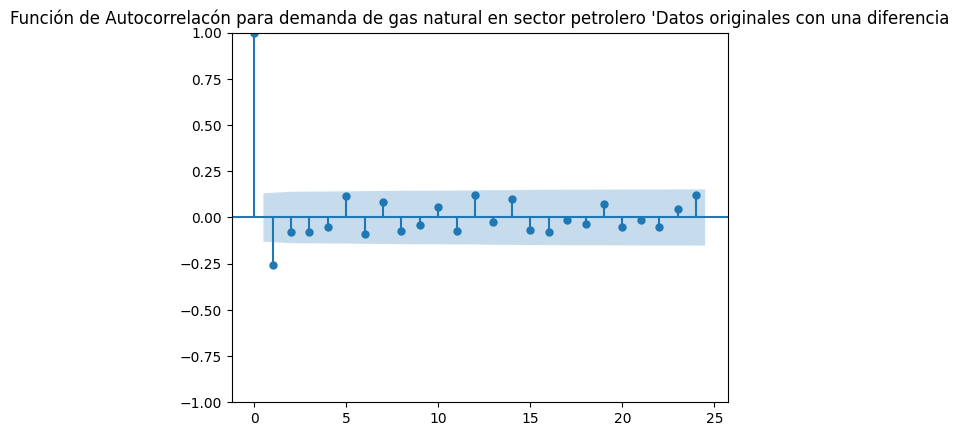

In [39]:
import statsmodels.graphics.tsaplots as tsaplot
# Create the Matplotlib axes object
fig, ax = plt.subplots()

# Plot the ACF
tsaplot.plot_acf(demanda_petrolero_original_diff1.dropna(), ax=ax)

# Set the title
ax.set_title("Función de Autocorrelacón para demanda de gas natural en sector petrolero 'Datos originales con una diferencia")

# Show the plot
plt.show()

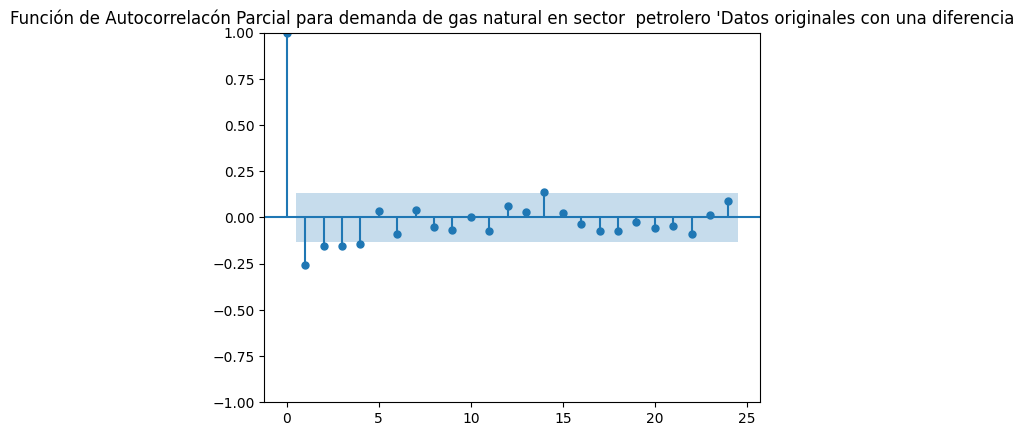

In [40]:
import statsmodels.graphics.tsaplots as tsaplot
# Create the Matplotlib axes object
fig, ax = plt.subplots()

# Plot the ACF
tsaplot.plot_pacf(demanda_petrolero_original_diff1.dropna(), ax=ax)

# Set the title
ax.set_title("Función de Autocorrelacón Parcial para demanda de gas natural en sector  petrolero 'Datos originales con una diferencia")

# Show the plot
plt.show()

### Se define y entrena modelo ARIMA para el caso de la data original de Demanda en el sector petrolero

In [41]:
##Create the model
model_ARIMA_petrolero_original = ARIMA (demanda_petrolero_original_train_data, order=(4,1,1))

##Fit the model
start = time()
model_ARIMA_petrolero_original_fit = model_ARIMA_petrolero_original.fit()
end = time()
print('Model fitting time', end-start)

##Summary of the model 
print(model_ARIMA_petrolero_original_fit.summary())

c:\Users\llell\OneDrive\Documentos\MIS\MIS_tesis_follow_full_Desktop_Dell\TESIS_GIT_Desktop_Dell\MIS_Tesis_Venv1\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\llell\OneDrive\Documentos\MIS\MIS_tesis_follow_full_Desktop_Dell\TESIS_GIT_Desktop_Dell\MIS_Tesis_Venv1\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\llell\OneDrive\Documentos\MIS\MIS_tesis_follow_full_Desktop_Dell\TESIS_GIT_Desktop_Dell\MIS_Tesis_Venv1\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Model fitting time 0.6186246871948242
                               SARIMAX Results                                
Dep. Variable:           Demanded_Gas   No. Observations:                  213
Model:                 ARIMA(4, 1, 1)   Log Likelihood               -1188.977
Date:                Mon, 29 Apr 2024   AIC                           2389.954
Time:                        11:31:15   BIC                           2410.094
Sample:                    01-01-2005   HQIC                          2398.094
                         - 09-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3531      0.250      1.414      0.157      -0.136       0.843
ar.L2         -0.0291      0.109     -0.266      0.790      -0.243       0.185
ar.L3         

In [42]:
##get prediction start and end dates 
pred_model_ARIMA_petrolero_start_date = demanda_petrolero_original_test_data.index[0]
pred_model_ARIMA_petrolero_end_date = demanda_petrolero_original_test_data.index[-1]

##get the predictors and residuals 
predictions_model_ARIMA_petrolero_original = model_ARIMA_petrolero_original_fit.predict(start=pred_model_ARIMA_petrolero_start_date, end= pred_model_ARIMA_petrolero_end_date)
predictions_model_ARIMA_petrolero_original


2022-10-01    1948.347519
2022-11-01    1946.333065
2022-12-01    1950.929612
2023-01-01    1951.950772
2023-02-01    1952.162188
2023-03-01    1951.883454
2023-04-01    1951.794051
2023-05-01    1951.774925
2023-06-01    1951.791941
2023-07-01    1951.799313
2023-08-01    1951.801080
2023-09-01    1951.800090
Freq: MS, Name: predicted_mean, dtype: float64

In [43]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import numpy as np

# Compute errors
MAPE_predictions_model_ARIMA_petrolero_original = mean_absolute_percentage_error(demanda_petrolero_original_test_data['Demanded_Gas'].values, predictions_model_ARIMA_petrolero_original)
RMSE_predictions_model_ARIMA_petrolero_original = np.sqrt(mean_squared_error(demanda_petrolero_original_test_data['Demanded_Gas'].values, predictions_model_ARIMA_petrolero_original))

print('MAPE:', MAPE_predictions_model_ARIMA_petrolero_original)
print('RMSE:', RMSE_predictions_model_ARIMA_petrolero_original)

MAPE: 0.15355929963869508
RMSE: 287.3823189342597


Text(0, 0.5, 'Demanda [MMpcd]')

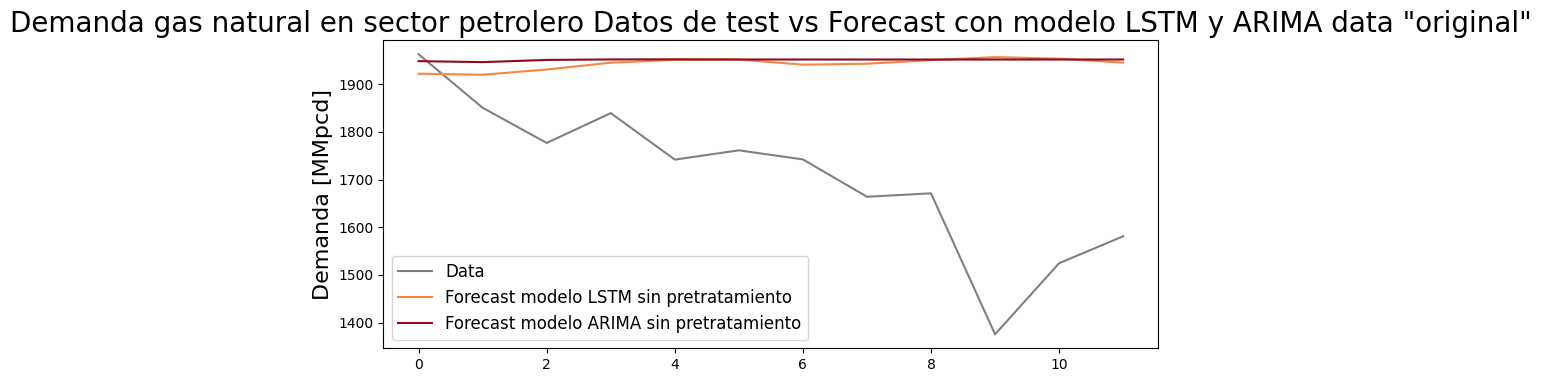

In [44]:
##Ploting the predicitons vs the test_data
plt.figure(figsize =(10,4))
plt.plot(demanda_petrolero_original_test_data['Demanded_Gas'].values, color='gray')
plt.plot(test_predictions_model_LSTM_petrolero_original, color='#F8873E')
plt.plot(predictions_model_ARIMA_petrolero_original.values, color='#92071C')
plt.legend(('Data', 'Forecast modelo LSTM sin pretratamiento', 'Forecast modelo ARIMA sin pretratamiento'), fontsize=12)

plt.title('Demanda gas natural en sector petrolero Datos de test vs Forecast con modelo LSTM y ARIMA data "original"', fontsize=20)
plt.ylabel('Demanda [MMpcd]', fontsize=16)

## Proceso de Pretratamiento (Ajuste de valores atípicos por media aritmetica o mediana de serie) como una estrategia para mejorar los resultados de forecast de modelos LSTM Neural Networks

## Proceso de Pretratamiento Ajuste de valores atípicos por media aritmetica 

In [45]:
outlier_threshold = 1.25

import pandas as pd

def remove_replace_outliers_media(data):
    # Calculate Q1 and Q3
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1

    # Identify outliers
    outliers_mask = (data < (Q1 - outlier_threshold * IQR)) | (data > (Q3 + outlier_threshold * IQR))

    # Calculate the historical mean excluding outliers
    historical_mean = data[~outliers_mask].mean()

    # Replace outliers with historical mean
    data.loc[outliers_mask] = historical_mean

    return data

Se genera una copia del csv_demanda_electrico_original para conservar los datos originales en un array y éstos no se vean afectados por el tratamiento de valores atípicos 

In [46]:
demanda_petrolero_original_train_para_tratamiento =demanda_petrolero_original_train_data.copy()
demanda_petrolero_original_train_para_tratamiento

,Demanded_Gas
Date,
2005-01-01,2039.875
2005-02-01,2015.255
2005-03-01,1969.507
2005-04-01,2008.187
2005-05-01,2041.864
...,...
2022-05-01,1919.429
2022-06-01,1878.572
2022-07-01,1979.696


In [47]:
demanda_petrolero_train_pretratamiento_media = remove_replace_outliers_media(demanda_petrolero_original_train_para_tratamiento['Demanded_Gas'])
demanda_petrolero_train_pretratamiento_media

Date
2005-01-01    2039.875
2005-02-01    2015.255
2005-03-01    1969.507
2005-04-01    2008.187
2005-05-01    2041.864
                ...   
2022-05-01    1919.429
2022-06-01    1878.572
2022-07-01    1979.696
2022-08-01    2024.823
2022-09-01    1956.582
Name: Demanded_Gas, Length: 213, dtype: float64

Text(0, 0.5, 'Demanda [MMpcd]')

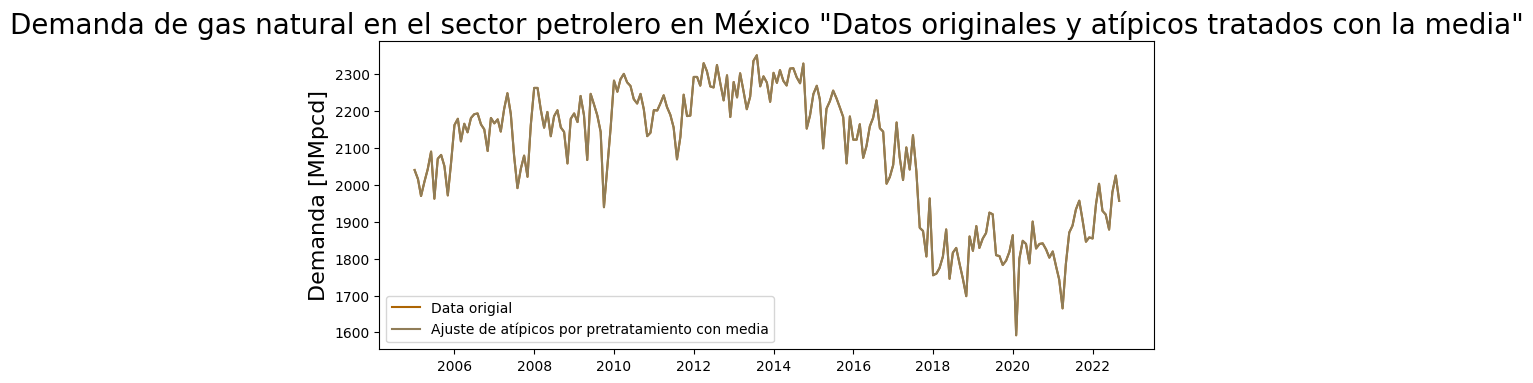

In [48]:
plt.figure(figsize=(10,4))
plt.plot(demanda_petrolero_original_train_data, color='#AD6503')
plt.plot(demanda_petrolero_train_pretratamiento_media,color='#907D58')
plt.legend(('Data origial', 'Ajuste de atípicos por pretratamiento con media'))
plt.title('Demanda de gas natural en el sector petrolero en México "Datos originales y atípicos tratados con la media"', fontsize=20)
plt.ylabel('Demanda [MMpcd]', fontsize =16)

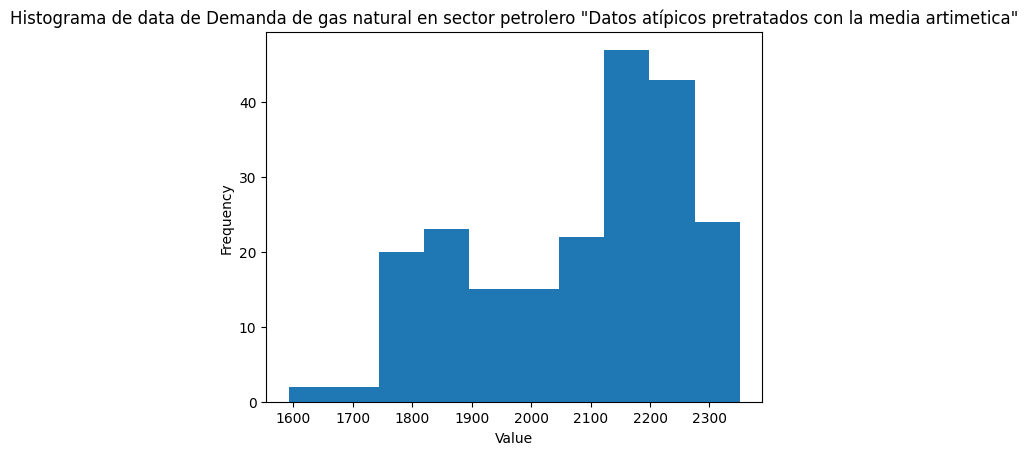

In [49]:
# Generate the histogram
plt.hist(demanda_petrolero_train_pretratamiento_media, bins=10)  # Adjust the number of bins as per your data

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histograma de data de Demanda de gas natural en sector petrolero "Datos atípicos pretratados con la media artimetica"')

# Display the plot
plt.show()

In [50]:
demanda_petrolero_train_pretratamiento_media.describe()

count     213.000000
mean     2082.555484
std       176.114805
min      1592.280000
25%      1933.018000
50%      2143.112000
75%      2224.715000
max      2350.709000
Name: Demanded_Gas, dtype: float64

In [51]:
import scipy.stats as stats

# Assuming demanda_electrico_original_train_data is a pandas Series or DataFrame
# You can access the values as follows:
data = demanda_petrolero_train_pretratamiento_media.values

# Perform the Jarque-Bera test
jb_statistic, jb_p_value = stats.jarque_bera(data)

# Check the p-value to determine whether the data follows a normal distribution
alpha = 0.05  # Significance level
if jb_p_value < alpha:
    print(f"La data NO sigue una distribución normal")
else:
    print("La data SI sigue una distribución normal")

# Optionally, you can also print the JB statistic and p-value
print("Jarque-Bera Statistic:", jb_statistic)
print("p-value:", jb_p_value)

La data NO sigue una distribución normal
Jarque-Bera Statistic: 18.08888224642761
p-value: 0.00011804541635138615


Y se observa que en este caso el tratamiento de la data si ayudó a que la data de entrenamiento pasara la prueba Jarque-Bera de normalidad 

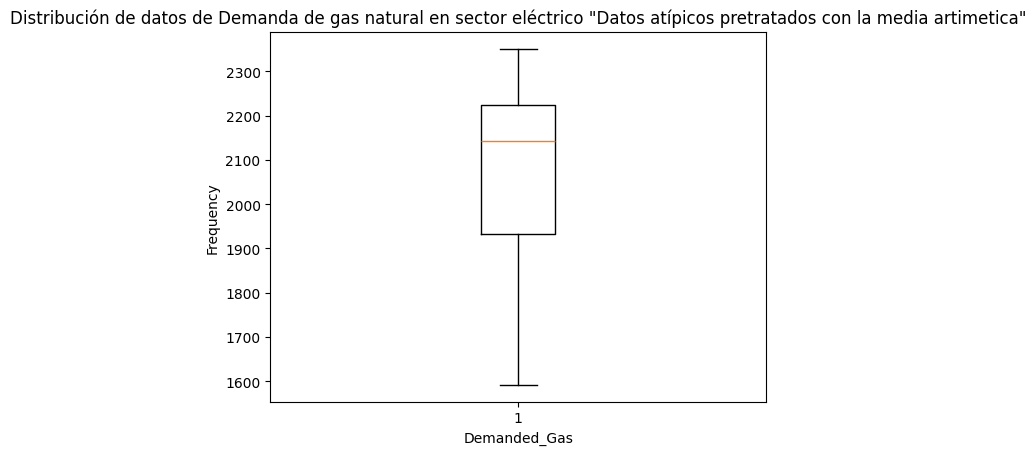

In [52]:
# Create a boxplot of the Demanded_Gas column
plt.boxplot(demanda_petrolero_train_pretratamiento_media)

# Add labels and title
plt.xlabel('Demanded_Gas')
plt.ylabel('Frequency')
plt.title('Distribución de datos de Demanda de gas natural en sector eléctrico "Datos atípicos pretratados con la media artimetica"')

# Display the plot
plt.show()

Se generan sets de n_input datos para con ellos predecir el t+1 dato, y así los siguientes n_input para predecir el t+1, etc 

In [53]:
n_input = 12

data = demanda_petrolero_train_pretratamiento_media
targets = data 

demanda_petrolero_train_generator_pretratamiento_media = TimeseriesGenerator(data, targets, length=n_input, batch_size=1)


In [54]:
demanda_petrolero_train_generator_pretratamiento_media[0]

c:\Users\llell\OneDrive\Documentos\MIS\MIS_tesis_follow_full_Desktop_Dell\TESIS_GIT_Desktop_Dell\MIS_Tesis_Venv1\Lib\site-packages\keras\src\legacy\preprocessing\sequence.py:120: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  targets = np.array([self.targets[row] for row in rows])


(array([[2039.875, 2015.255, 1969.507, 2008.187, 2041.864, 2089.819,
         1962.257, 2070.458, 2080.82 , 2050.558, 1971.142, 2059.679]]),
 array([2161.658]))

Y entonces el numero de muestras formadas con el TimeseriesGenerator = Numero de elementos de array original - n_input

In [55]:
print("Total number of samples in the original training data = ", len(demanda_petrolero_train_pretratamiento_media)) 
print("Total number of samples in the demanda_electrico_scaled_train_generator = ", len(demanda_petrolero_train_generator_pretratamiento_media))

Total number of samples in the original training data =  213
Total number of samples in the demanda_electrico_scaled_train_generator =  201


Se define la red neuronal sequencial LSTM con capas densas y funcion de activación tipo RELU.  

In [56]:
seed_value=2024

import numpy as np
np.random.seed(seed_value)


import tensorflow as tf
tf.random.set_seed(seed_value)



In [57]:
n_input = n_input
n_features = n_features

# define model
model_LSTM_petrolero_pretratamiento_media = Sequential()
model_LSTM_petrolero_pretratamiento_media.add(LSTM(50, activation='relu', input_shape=(n_input, n_features)))
model_LSTM_petrolero_pretratamiento_media.add(Dense(1))
model_LSTM_petrolero_pretratamiento_media.compile(optimizer='adam', loss='mse')

c:\Users\llell\OneDrive\Documentos\MIS\MIS_tesis_follow_full_Desktop_Dell\TESIS_GIT_Desktop_Dell\MIS_Tesis_Venv1\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [58]:
model_LSTM_petrolero_pretratamiento_media.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

Entrenamos el modelo  Feed Forward Sequential Neural Network con el demanda_electrico_scaled_train_generator.
Es decir se está entrenando al modelo para que con los valores de entrenamiento "ajuste sus pesos y bias" de manera que se esté tomando n_inputs como "variables predictoas" y el +1 valor después de los n_input como variable dependiente Y. y asñi se va recorriendo el n_input. De manera que se tienen n_total_elementos_en_train - n_input valores de entrada de tamaño n_input y n_total_elementos_en_train - n_input valores de salida de tamaño 1 (Representando la Y calculada)  

In [59]:
model_LSTM_petrolero_pretratamiento_media.fit(demanda_petrolero_train_generator_pretratamiento_media, epochs=12)

Epoch 1/12


 59/201 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4046424.7500

c:\Users\llell\OneDrive\Documentos\MIS\MIS_tesis_follow_full_Desktop_Dell\TESIS_GIT_Desktop_Dell\MIS_Tesis_Venv1\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


201/201 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 3442679.5000
Epoch 2/12
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 232910.7031
Epoch 3/12
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6814.6211
Epoch 4/12
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7355.5078
Epoch 5/12
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7188.9873
Epoch 6/12
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7769.8818
Epoch 7/12
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5737.1035
Epoch 8/12
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 10100.5117
Epoch 9/12
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 12081.3457
Epoch 10/12
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6461.1382
Epoch 11/12
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7387.6162
Epoch 12/12
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6720.9521


Se grafica la perdida por epoch 

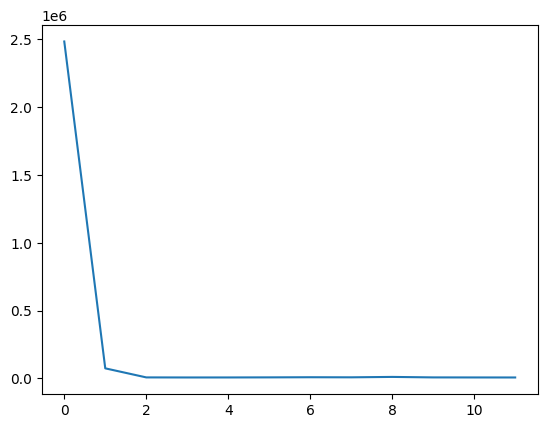

In [60]:
loss_per_epoch = model_LSTM_petrolero_pretratamiento_media.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

Se lleva a cabo el forecast de los ultimos 12 meses usando el modelo model_sequential_and_FF previamente definido y entrenado

Se toman los **ULTIMOS** n_input elementos de los **datos de train** y se almacenan en un batch

In [61]:
demanda_petrolero_train_batch_pretratamiento_media = demanda_petrolero_train_pretratamiento_media[-n_input:]


demanda_petrolero_train_batch_pretratamiento_media

Date
2021-10-01    1904.215
2021-11-01    1845.705
2021-12-01    1857.401
2022-01-01    1854.424
2022-02-01    1947.411
2022-03-01    2002.632
2022-04-01    1929.430
2022-05-01    1919.429
2022-06-01    1878.572
2022-07-01    1979.696
2022-08-01    2024.823
2022-09-01    1956.582
Name: Demanded_Gas, dtype: float64

Se reescala el batch de los datos de train a que tenga la misma forma que los datos con que se entrenó el modelo que fueron  1, input_shape=(n_input, n_features)

In [62]:
demanda_petrolero_train_batch_pretratamiento_media_reshaped = demanda_petrolero_train_batch_pretratamiento_media.values.reshape(1,n_input, n_features)
demanda_petrolero_train_batch_pretratamiento_media_reshaped

array([[[1904.215],
        [1845.705],
        [1857.401],
        [1854.424],
        [1947.411],
        [2002.632],
        [1929.43 ],
        [1919.429],
        [1878.572],
        [1979.696],
        [2024.823],
        [1956.582]]])

Intentamos predecir el sigueinte valor dado el primet batch de n_input. Esto equivaldria a predecir el primer valor de los datos de test (PUES SE ESTÁN TOMANDO EXACTAMENTE LOS ULTIMOS VALORES DE LOS DATOS DE TRAIN EN EL BATCH), dados los n_input anteriores (QUE FORMAN BARTE DEL BATCH)

In [63]:
model_LSTM_petrolero_pretratamiento_media.predict(demanda_petrolero_train_batch_pretratamiento_media_reshaped)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


array([[1929.147]], dtype=float32)

Y se compara el valor de forecast del modelo LSTM + pretratamiento media + normalizacion con los datos de test de la demanda de gas natural en sector eléctrico

In [64]:
demanda_petrolero_original_test_data

,Demanded_Gas
Date,
2022-10-01,1962.773
2022-11-01,1850.566
2022-12-01,1776.714
2023-01-01,1839.367
2023-02-01,1741.797
2023-03-01,1761.295
2023-04-01,1742.201
2023-05-01,1663.904
2023-06-01,1671.033


Ahora ser hará una función que irá formando batch de n_input para ir prediciendo el siguiente valor, tal como se hizo en el entrenamiento del modelo

In [65]:
n_input = n_input
n_features = n_features

In [66]:
demanda_petrolero_train_pretratamiento_media[-n_input:]

Date
2021-10-01    1904.215
2021-11-01    1845.705
2021-12-01    1857.401
2022-01-01    1854.424
2022-02-01    1947.411
2022-03-01    2002.632
2022-04-01    1929.430
2022-05-01    1919.429
2022-06-01    1878.572
2022-07-01    1979.696
2022-08-01    2024.823
2022-09-01    1956.582
Name: Demanded_Gas, dtype: float64

In [67]:
test_predictions_model_LSTM_petrolero_pretratamiento_media  = []

first_eval_batch = demanda_petrolero_train_pretratamiento_media[-n_input:].values
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(demanda_petrolero_original_test_data)):
    
    # get the prediction value for the first batch
    current_pred = model_LSTM_petrolero_pretratamiento_media.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions_model_LSTM_petrolero_pretratamiento_media.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
    current_batch = current_batch.reshape((1, n_input, n_features))  # Reshape to maintain the 3D shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


In [68]:
test_predictions_model_LSTM_petrolero_pretratamiento_media

[array([1929.147], dtype=float32),
 array([1932.622], dtype=float32),
 array([1944.6934], dtype=float32),
 array([1950.9694], dtype=float32),
 array([1950.7727], dtype=float32),
 array([1947.1929], dtype=float32),
 array([1947.5223], dtype=float32),
 array([1956.3955], dtype=float32),
 array([1959.7931], dtype=float32),
 array([1957.5773], dtype=float32),
 array([1953.9202], dtype=float32),
 array([1951.985], dtype=float32)]

In [69]:
demanda_petrolero_original_test_data['Demanded_Gas'].values

array([1962.773, 1850.566, 1776.714, 1839.367, 1741.797, 1761.295,
       1742.201, 1663.904, 1671.033, 1375.367, 1524.381, 1580.999])

Text(0, 0.5, 'Demanda [MMpcd]')

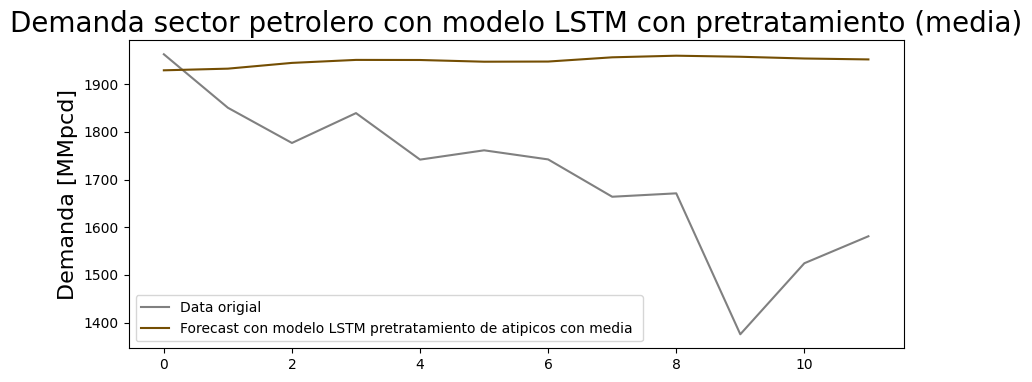

In [70]:
##Ploting the predicitons vs the test_data
plt.figure(figsize =(10,4))
plt.plot(demanda_petrolero_original_test_data['Demanded_Gas'].values, color='gray')
plt.plot(test_predictions_model_LSTM_petrolero_pretratamiento_media , color='#744E03')
plt.legend(('Data', 'Predictions'), fontsize=16)
plt.legend(('Data origial', 'Forecast con modelo LSTM pretratamiento de atipicos con media '))

plt.title('Demanda sector petrolero con modelo LSTM con pretratamiento (media)', fontsize=20)
plt.ylabel('Demanda [MMpcd]', fontsize=16)

In [71]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import numpy as np

# Compute errors
MAPE_test_predictions_model_LSTM_petrolero_pretratamiento_media = mean_absolute_percentage_error(demanda_petrolero_original_test_data['Demanded_Gas'].values, test_predictions_model_LSTM_petrolero_pretratamiento_media)
RMSE_test_predictions_model_LSTM_petrolero_pretratamiento_media = np.sqrt(mean_squared_error(demanda_petrolero_original_test_data['Demanded_Gas'].values, test_predictions_model_LSTM_petrolero_pretratamiento_media))

print('MAPE:', MAPE_test_predictions_model_LSTM_petrolero_pretratamiento_media)
print('RMSE:', RMSE_test_predictions_model_LSTM_petrolero_pretratamiento_media)

MAPE: 0.15403347318115865
RMSE: 288.52480021938874


Se muestra la comparación del forecast de demanda petrolero con modelo LSTM entre train data sin pretratamiento y con pretratamiento de atípicos con la media

Text(0, 0.5, 'Demanda [MMpcd]')

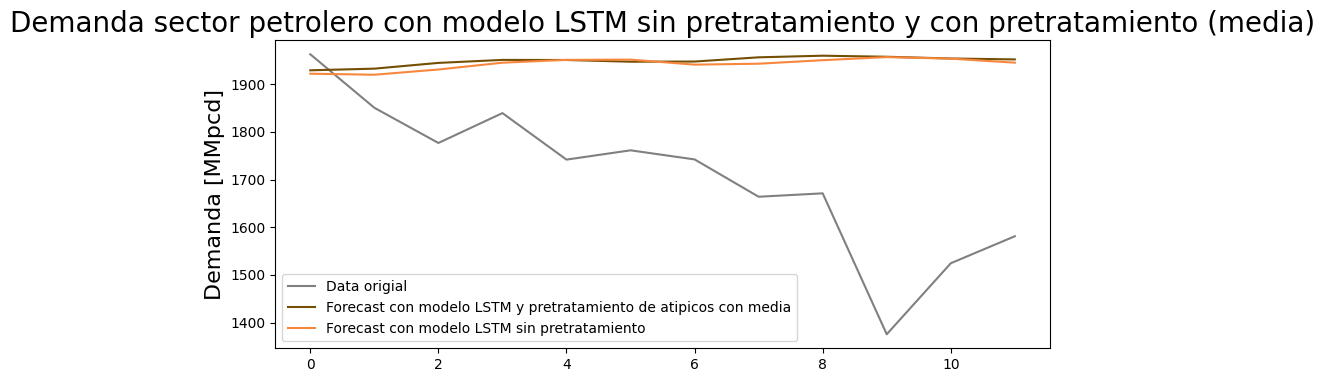

In [72]:
##Ploting the predicitons vs the test_data
plt.figure(figsize =(10,4))
plt.plot(demanda_petrolero_original_test_data['Demanded_Gas'].values, color='gray')
plt.plot(test_predictions_model_LSTM_petrolero_pretratamiento_media , color='#744E03')
plt.plot(test_predictions_model_LSTM_petrolero_original, color='#F8873E')
plt.legend(('Data', 'Predictions'), fontsize=16)
plt.legend(('Data origial', 'Forecast con modelo LSTM y pretratamiento de atipicos con media', 'Forecast con modelo LSTM sin pretratamiento'))

plt.title('Demanda sector petrolero con modelo LSTM sin pretratamiento y con pretratamiento (media)', fontsize=20)
plt.ylabel('Demanda [MMpcd]', fontsize=16)

Apliquemos un modelo ARIMA a nuestra data de Demanda de gas natural en sector eléctrico 'Datos atipicos con tratamiento media'

In [73]:
##Create the model
model_ARIMA_petrolero_tratamiento_media = ARIMA (demanda_petrolero_train_pretratamiento_media, order=(3,1,1))

##Fit the model
start = time()
model_ARIMA_petrolero_tratamiento_media_fit = model_ARIMA_petrolero_tratamiento_media.fit()
end = time()
print('Model fitting time', end-start)

##Summary of the model 
print(model_ARIMA_petrolero_tratamiento_media_fit.summary())

c:\Users\llell\OneDrive\Documentos\MIS\MIS_tesis_follow_full_Desktop_Dell\TESIS_GIT_Desktop_Dell\MIS_Tesis_Venv1\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\llell\OneDrive\Documentos\MIS\MIS_tesis_follow_full_Desktop_Dell\TESIS_GIT_Desktop_Dell\MIS_Tesis_Venv1\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\llell\OneDrive\Documentos\MIS\MIS_tesis_follow_full_Desktop_Dell\TESIS_GIT_Desktop_Dell\MIS_Tesis_Venv1\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Model fitting time 0.47893333435058594
                               SARIMAX Results                                
Dep. Variable:           Demanded_Gas   No. Observations:                  213
Model:                 ARIMA(3, 1, 1)   Log Likelihood               -1188.996
Date:                Mon, 29 Apr 2024   AIC                           2387.992
Time:                        11:31:28   BIC                           2404.775
Sample:                    01-01-2005   HQIC                          2394.775
                         - 09-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3316      0.160      2.069      0.039       0.017       0.646
ar.L2         -0.0367      0.091     -0.404      0.687      -0.215       0.142
ar.L3        

In [74]:
##get prediction start and end dates 
pred_model_ARIMA_petrolero_start_date = demanda_petrolero_original_test_data.index[0]
pred_model_ARIMA_petrolero_end_date = demanda_petrolero_original_test_data.index[-1]

In [75]:
##get the predictors and residuals 
predictions_model_ARIMA_petrolero_tratamiento_media = model_ARIMA_petrolero_tratamiento_media_fit.predict(start=pred_model_ARIMA_petrolero_start_date, end= pred_model_ARIMA_petrolero_end_date)
print(predictions_model_ARIMA_petrolero_tratamiento_media)

2022-10-01    1949.489099
2022-11-01    1946.699788
2022-12-01    1950.484094
2023-01-01    1952.303786
2023-02-01    1952.950150
2023-03-01    1952.850983
2023-04-01    1952.675741
2023-05-01    1952.579130
2023-06-01    1952.559991
2023-07-01    1952.568615
2023-08-01    1952.578476
2023-09-01    1952.582677
Freq: MS, Name: predicted_mean, dtype: float64


In [76]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import numpy as np

# Compute errors
MAPE_predictions_model_ARIMA_petrolero_tratamiento_media = mean_absolute_percentage_error(demanda_petrolero_original_test_data['Demanded_Gas'].values, predictions_model_ARIMA_petrolero_tratamiento_media)
RMSE_predictions_model_ARIMA_petrolero_tratamiento_media= np.sqrt(mean_squared_error(demanda_petrolero_original_test_data['Demanded_Gas'].values, predictions_model_ARIMA_petrolero_tratamiento_media))

print('MAPE:', MAPE_predictions_model_ARIMA_petrolero_tratamiento_media)
print('RMSE:', RMSE_predictions_model_ARIMA_petrolero_tratamiento_media)

MAPE: 0.15385703069494253
RMSE: 287.9710465008965


Text(0, 0.5, 'Demanda [MMpcd]')

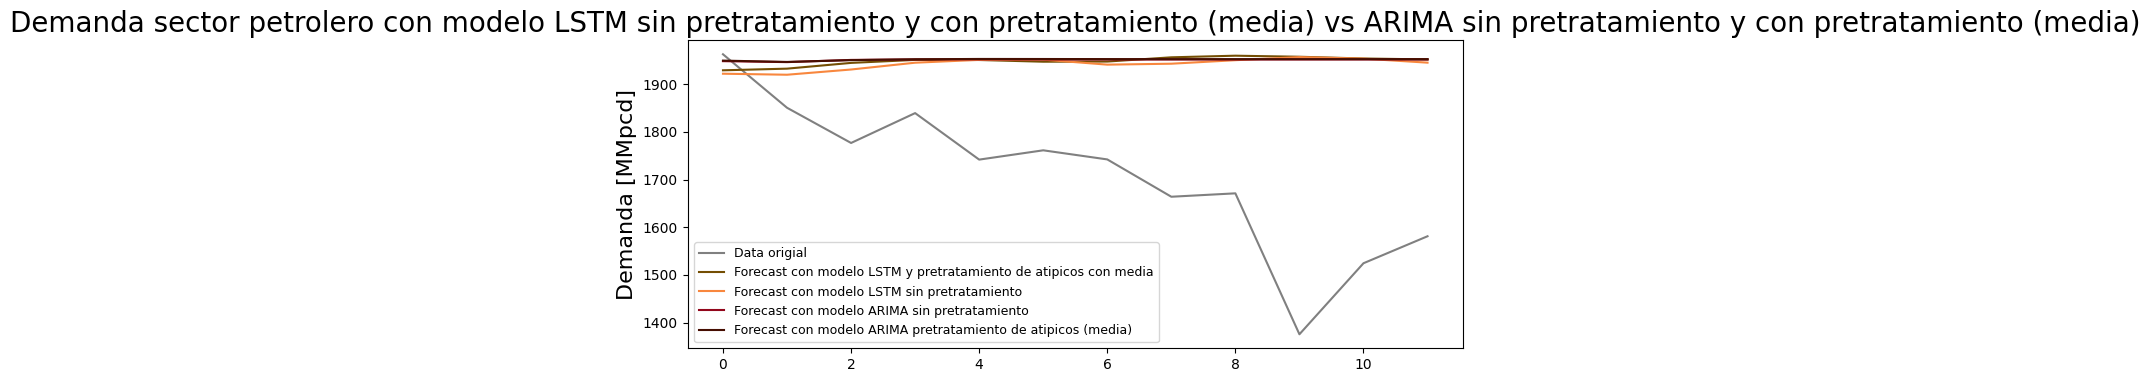

In [80]:
##Ploting the predicitons vs the test_data
plt.figure(figsize =(10,4))


plt.plot(demanda_petrolero_original_test_data['Demanded_Gas'].values, color='gray')
plt.plot(test_predictions_model_LSTM_petrolero_pretratamiento_media , color='#744E03')
plt.plot(test_predictions_model_LSTM_petrolero_original, color='#F8873E')

plt.plot(predictions_model_ARIMA_petrolero_original.values, color='#92071C')

plt.plot(predictions_model_ARIMA_petrolero_tratamiento_media.values,color='#460E01')

plt.legend(('Data', 'Predictions'), fontsize=16)
plt.legend(('Data origial', 'Forecast con modelo LSTM y pretratamiento de atipicos con media', 'Forecast con modelo LSTM sin pretratamiento', 'Forecast con modelo ARIMA sin pretratamiento ', 'Forecast con modelo ARIMA pretratamiento de atipicos (media)' ), fontsize=9)

plt.title('Demanda sector petrolero con modelo LSTM sin pretratamiento y con pretratamiento (media) vs ARIMA sin pretratamiento y con pretratamiento (media)', fontsize=20)
plt.ylabel('Demanda [MMpcd]', fontsize=16)

## Proceso de Pretratamiento Ajuste de valores atípicos por mediana 

In [81]:
outlier_threshold = 1.2

import pandas as pd

def remove_replace_outliers_mediana(data):
    # Calculate Q1 and Q3
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1

    # Identify outliers
    outliers_mask = (data < (Q1 - outlier_threshold * IQR)) | (data > (Q3 + outlier_threshold * IQR))

    # Calculate the historical meadian excluding outliers
    historical_median = np.median(data[~outliers_mask])

    # Replace outliers with historical mean
    data.loc[outliers_mask] = historical_median

    return data

In [82]:
demanda_petrolero_original_train_para_tratamiento2 = demanda_petrolero_original_train_data.copy()
demanda_petrolero_original_train_para_tratamiento2

,Demanded_Gas
Date,
2005-01-01,2039.875
2005-02-01,2015.255
2005-03-01,1969.507
2005-04-01,2008.187
2005-05-01,2041.864
...,...
2022-05-01,1919.429
2022-06-01,1878.572
2022-07-01,1979.696


In [83]:
demanda_petrolero_train_pretratamiento_mediana = remove_replace_outliers_mediana(demanda_petrolero_original_train_para_tratamiento2['Demanded_Gas'])
demanda_petrolero_train_pretratamiento_mediana

Date
2005-01-01    2039.875
2005-02-01    2015.255
2005-03-01    1969.507
2005-04-01    2008.187
2005-05-01    2041.864
                ...   
2022-05-01    1919.429
2022-06-01    1878.572
2022-07-01    1979.696
2022-08-01    2024.823
2022-09-01    1956.582
Name: Demanded_Gas, Length: 213, dtype: float64

Text(0, 0.5, 'Demanda [MMpcd]')

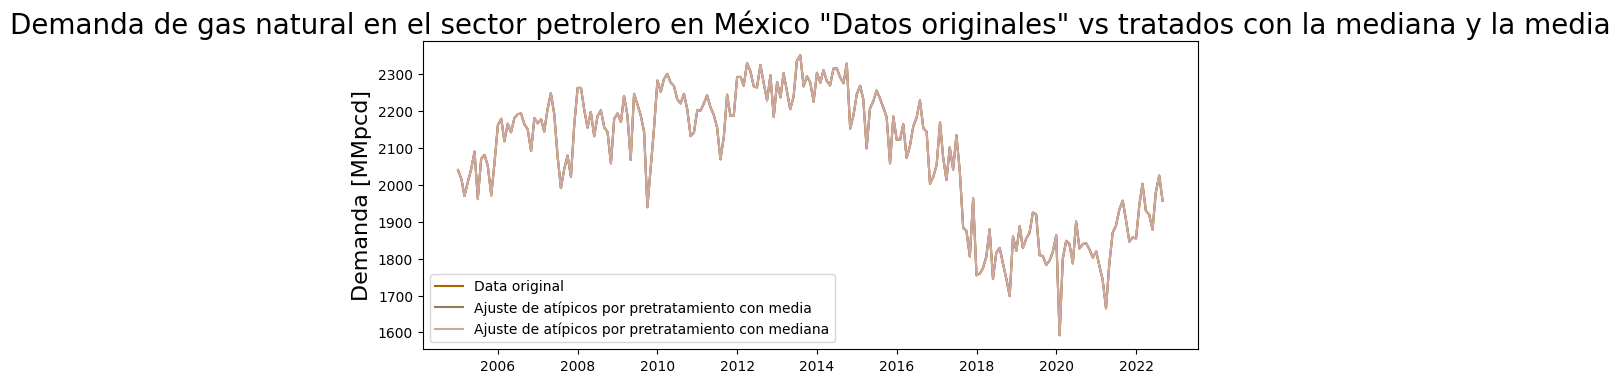

In [86]:
plt.figure(figsize=(10,4))

plt.plot(demanda_petrolero_original_train_data, color='#AD6503')
plt.plot(demanda_petrolero_train_pretratamiento_media,color='#907D58')

plt.plot(demanda_petrolero_train_pretratamiento_mediana, color= '#CEA8A0')


plt.legend(('Data original', 'Ajuste de atípicos por pretratamiento con media', 'Ajuste de atípicos por pretratamiento con mediana'))
plt.title('Demanda de gas natural en el sector petrolero en México "Datos originales" vs tratados con la mediana y la media', fontsize=20)
plt.ylabel('Demanda [MMpcd]', fontsize =16)

Se descompone la data con pretratamiento de mediana de Demanda en sector eléctrico en sus componentes de Tendencia, Estacionalidad y Residual

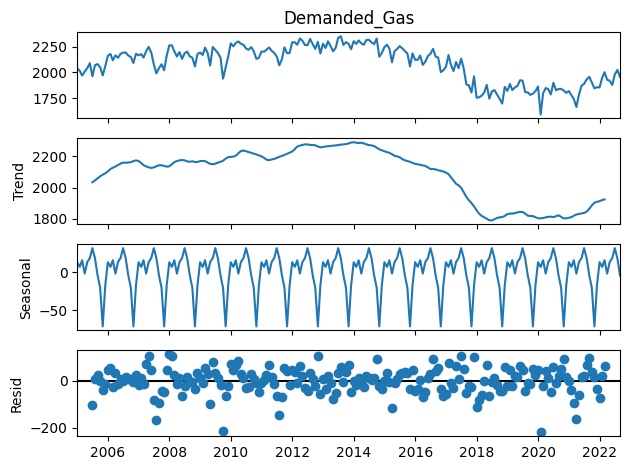

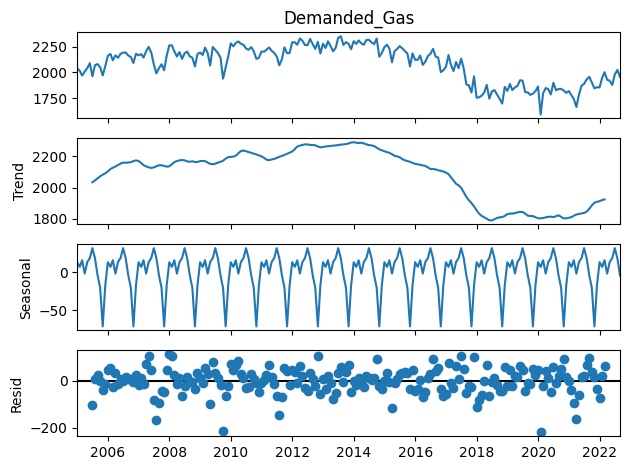

In [87]:
from statsmodels.tsa.seasonal import seasonal_decompose

demanda_petrolero_train_pretratamiento_mediana_seasonal_decomposition = seasonal_decompose(demanda_petrolero_train_pretratamiento_mediana)
demanda_petrolero_train_pretratamiento_mediana_seasonal_decomposition.plot()


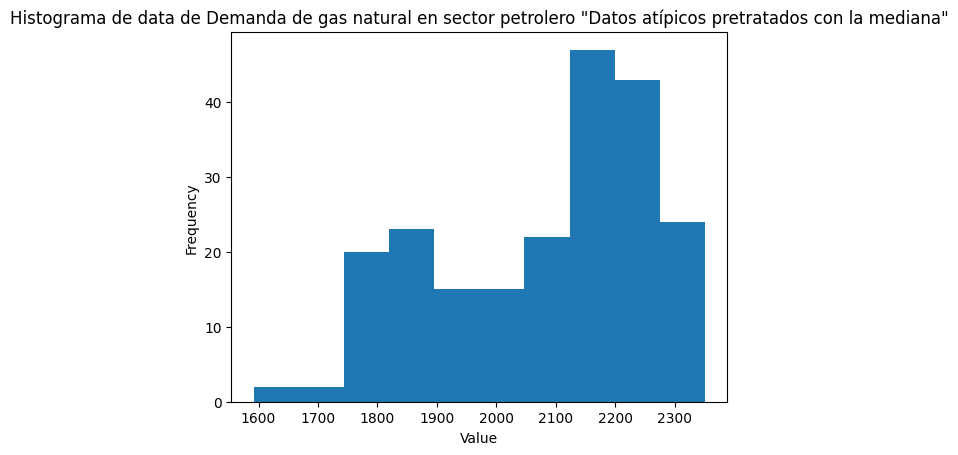

In [88]:
# Generate the histogram
plt.hist(demanda_petrolero_train_pretratamiento_mediana, bins=10)  # Adjust the number of bins as per your data

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histograma de data de Demanda de gas natural en sector petrolero "Datos atípicos pretratados con la mediana"')

# Display the plot
plt.show()

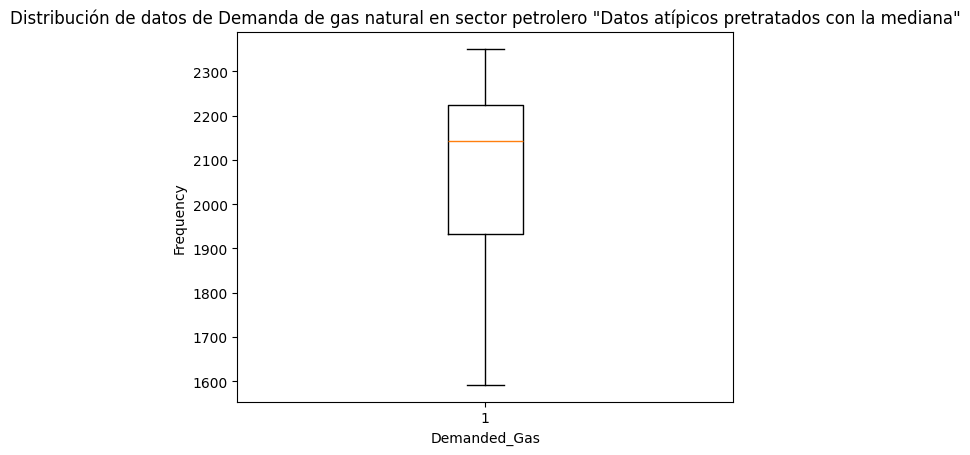

In [89]:
# Create a boxplot of the Demanded_Gas column
plt.boxplot(demanda_petrolero_train_pretratamiento_mediana)

# Add labels and title
plt.xlabel('Demanded_Gas')
plt.ylabel('Frequency')
plt.title('Distribución de datos de Demanda de gas natural en sector petrolero "Datos atípicos pretratados con la mediana"')

# Display the plot
plt.show()

In [90]:
demanda_petrolero_train_pretratamiento_mediana.describe()

count     213.000000
mean     2082.555484
std       176.114805
min      1592.280000
25%      1933.018000
50%      2143.112000
75%      2224.715000
max      2350.709000
Name: Demanded_Gas, dtype: float64

In [91]:
import scipy.stats as stats

# Assuming demanda_electrico_original_train_data is a pandas Series or DataFrame
# You can access the values as follows:
data = demanda_petrolero_train_pretratamiento_mediana.values

# Perform the Jarque-Bera test
jb_statistic, jb_p_value = stats.jarque_bera(data)

# Check the p-value to determine whether the data follows a normal distribution
alpha = 0.05  # Significance level
if jb_p_value < alpha:
    print(f"La data NO sigue una distribución normal")
else:
    print("La data SI sigue una distribución normal")

# Optionally, you can also print the JB statistic and p-value
print("Jarque-Bera Statistic:", jb_statistic)
print("p-value:", jb_p_value)

La data NO sigue una distribución normal
Jarque-Bera Statistic: 18.08888224642761
p-value: 0.00011804541635138615


Se generan sets de n_input datos para con ellos predecir el t+1 dato, y así los siguientes n_input para predecir el t+1, etc

In [92]:
n_input = n_input 

data = demanda_petrolero_train_pretratamiento_mediana
targets = data 

demanda_petrolero_train_generator_pretratamiento_mediana = TimeseriesGenerator(data, targets, length=n_input, batch_size=1)
demanda_petrolero_train_generator_pretratamiento_mediana[0]

c:\Users\llell\OneDrive\Documentos\MIS\MIS_tesis_follow_full_Desktop_Dell\TESIS_GIT_Desktop_Dell\MIS_Tesis_Venv1\Lib\site-packages\keras\src\legacy\preprocessing\sequence.py:120: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  targets = np.array([self.targets[row] for row in rows])


(array([[2039.875, 2015.255, 1969.507, 2008.187, 2041.864, 2089.819,
         1962.257, 2070.458, 2080.82 , 2050.558, 1971.142, 2059.679]]),
 array([2161.658]))

Y entonces el numero de muestras formadas con el TimeseriesGenerator = Numero de elementos de array original - n_input

In [93]:
print("Total number of samples in the original training data = ", len(demanda_petrolero_train_pretratamiento_mediana)) 
print("Total number of samples in the demanda_electrico_scaled_train_generator = ", len(demanda_petrolero_train_generator_pretratamiento_mediana))

Total number of samples in the original training data =  213
Total number of samples in the demanda_electrico_scaled_train_generator =  201


Se define la red neuronal sequencial LSTM con capas densas y funcion de activación tipo RELU para el caso de la demanda en sector electrico con pretratamiento de mediana 

In [94]:
n_input = n_input
n_features = n_features

# define model
model_LSTM_petrolero_pretrataminto_mediana = Sequential()

model_LSTM_petrolero_pretrataminto_mediana.add(LSTM(50, activation='relu', input_shape=(n_input, n_features)))
model_LSTM_petrolero_pretrataminto_mediana.add(Dense(1))
model_LSTM_petrolero_pretrataminto_mediana.compile(optimizer='adam', loss='mse')

model_LSTM_petrolero_pretrataminto_mediana.summary()

c:\Users\llell\OneDrive\Documentos\MIS\MIS_tesis_follow_full_Desktop_Dell\TESIS_GIT_Desktop_Dell\MIS_Tesis_Venv1\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

Se entrena el modelo 

In [95]:
model_LSTM_petrolero_pretrataminto_mediana.fit(demanda_petrolero_train_generator_pretratamiento_mediana, epochs=15)

Epoch 1/15
 55/201 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 257210.2969

c:\Users\llell\OneDrive\Documentos\MIS\MIS_tesis_follow_full_Desktop_Dell\TESIS_GIT_Desktop_Dell\MIS_Tesis_Venv1\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


201/201 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 160201.9375
Epoch 2/15
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 10672.9688
Epoch 3/15
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 97442.6094 
Epoch 4/15
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 47226.8516
Epoch 5/15
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9401.2305
Epoch 6/15
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8170.0547
Epoch 7/15
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 9292.2725
Epoch 8/15
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9723.3574
Epoch 9/15
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 8060.5049
Epoch 10/15
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 8047.6113
Epoch 11/15
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6384.3643
Epoch 12/15
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7484.1069
Epoch 13/15
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 8240.6230
Epoch 14/15
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8434.3301
Epoch 15/15
201/201 

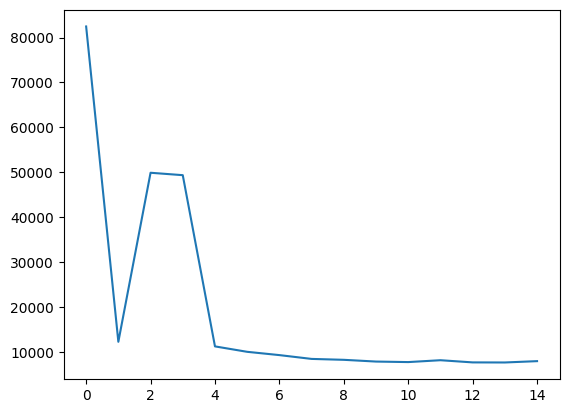

In [96]:
loss_per_epoch = model_LSTM_petrolero_pretrataminto_mediana.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

Se lleva a cabo el forecast de los ultimos 12 meses usando el modelo model_sequential_and_FF previamente definido y entrenado

Se toman los ULTIMOS n_input elementos de los datos de train y se almacenan en un batch

In [97]:
demanda_petrolero_train_pretratamiento_mediana

Date
2005-01-01    2039.875
2005-02-01    2015.255
2005-03-01    1969.507
2005-04-01    2008.187
2005-05-01    2041.864
                ...   
2022-05-01    1919.429
2022-06-01    1878.572
2022-07-01    1979.696
2022-08-01    2024.823
2022-09-01    1956.582
Name: Demanded_Gas, Length: 213, dtype: float64

In [98]:
demanda_petrolero_train_batch_pretratamiento_mediana = demanda_petrolero_train_pretratamiento_mediana[-n_input:]


demanda_petrolero_train_batch_pretratamiento_mediana

Date
2021-10-01    1904.215
2021-11-01    1845.705
2021-12-01    1857.401
2022-01-01    1854.424
2022-02-01    1947.411
2022-03-01    2002.632
2022-04-01    1929.430
2022-05-01    1919.429
2022-06-01    1878.572
2022-07-01    1979.696
2022-08-01    2024.823
2022-09-01    1956.582
Name: Demanded_Gas, dtype: float64

Se reescala el batch de los datos de train a que tenga la misma forma que los datos con que se entrenó el modelo que fueron 1, input_shape=(n_input, n_features)

In [99]:
demanda_petrolero_train_batch_pretratamiento_mediana_reshaped = demanda_petrolero_train_batch_pretratamiento_mediana.values.reshape(1,n_input, n_features)
demanda_petrolero_train_batch_pretratamiento_mediana_reshaped

array([[[1904.215],
        [1845.705],
        [1857.401],
        [1854.424],
        [1947.411],
        [2002.632],
        [1929.43 ],
        [1919.429],
        [1878.572],
        [1979.696],
        [2024.823],
        [1956.582]]])

Intentamos predecir el sigueinte valor dado el primet batch de n_input. Esto equivaldria a predecir el primer valor de los datos de test (PUES SE ESTÁN TOMANDO EXACTAMENTE LOS ULTIMOS VALORES DE LOS DATOS DE TRAIN EN EL BATCH), dados los n_input anteriores (QUE FORMAN BARTE DEL BATCH)

In [100]:
model_LSTM_petrolero_pretrataminto_mediana.predict(demanda_petrolero_train_batch_pretratamiento_mediana_reshaped)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


array([[1944.5553]], dtype=float32)

Ahora ser hará una función que irá formando batch de n_input para ir prediciendo el siguiente valor, tal como se hizo en el entrenamiento del modelo

In [101]:
n_input = n_input
n_features = n_features

In [102]:
test_predictions_model_LSTM_petrolero_pretratamiento_mediana  = []

first_eval_batch = demanda_petrolero_train_pretratamiento_mediana[-n_input:].values
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(demanda_petrolero_original_test_data['Demanded_Gas'])):
    
    # get the prediction value for the first batch
    current_pred = model_LSTM_petrolero_pretrataminto_mediana.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions_model_LSTM_petrolero_pretratamiento_mediana.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1) 
    current_batch = current_batch.reshape((1, n_input, n_features))  # Reshape to maintain the 3D shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


In [103]:
test_predictions_model_LSTM_petrolero_pretratamiento_mediana

[array([1944.5553], dtype=float32),
 array([1920.6517], dtype=float32),
 array([1933.8176], dtype=float32),
 array([1945.8145], dtype=float32),
 array([1961.0414], dtype=float32),
 array([1962.5732], dtype=float32),
 array([1944.858], dtype=float32),
 array([1949.1995], dtype=float32),
 array([1954.5303], dtype=float32),
 array([1965.6819], dtype=float32),
 array([1962.6064], dtype=float32),
 array([1953.1499], dtype=float32)]

Text(0, 0.5, 'Demanda [MMpcd]')

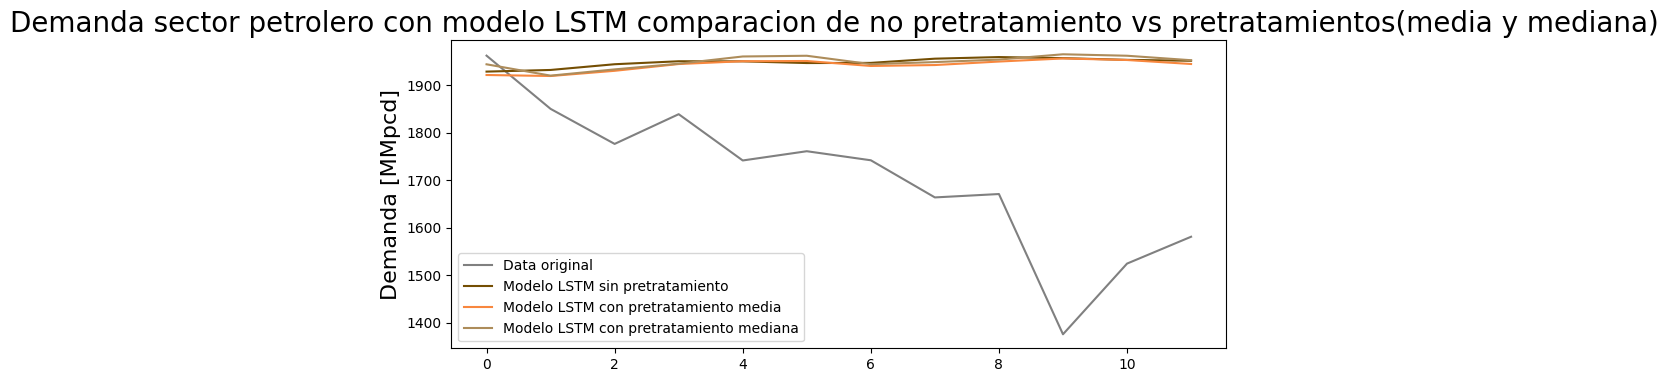

In [105]:
##Ploting the predicitons vs the test_data
plt.figure(figsize =(10,4))
plt.plot(demanda_petrolero_original_test_data['Demanded_Gas'].values, color='gray')

plt.plot(test_predictions_model_LSTM_petrolero_pretratamiento_media , color='#744E03')
plt.plot(test_predictions_model_LSTM_petrolero_original, color='#F8873E')
plt.plot(test_predictions_model_LSTM_petrolero_pretratamiento_mediana, color='#AD8C5A' )


plt.legend(('Data original', 'Modelo LSTM sin pretratamiento', 'Modelo LSTM con pretratamiento media', 'Modelo LSTM con pretratamiento mediana'), fontsize=10)

plt.title('Demanda sector petrolero con modelo LSTM comparacion de no pretratamiento vs pretratamientos(media y mediana) ', fontsize=20)
plt.ylabel('Demanda [MMpcd]', fontsize=16)

In [106]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import numpy as np

# Compute errors
MAPE_test_predictions_model_LSTM_petrolero_pretratamiento_mediana = mean_absolute_percentage_error(demanda_petrolero_original_test_data['Demanded_Gas'].values, test_predictions_model_LSTM_petrolero_pretratamiento_mediana)
RMSE_test_predictions_model_LSTM_petrolero_pretratamiento_mediana = np.sqrt(mean_squared_error(demanda_petrolero_original_test_data['Demanded_Gas'].values, test_predictions_model_LSTM_petrolero_pretratamiento_mediana))

print('MAPE:', MAPE_test_predictions_model_LSTM_petrolero_pretratamiento_mediana)
print('RMSE:', RMSE_test_predictions_model_LSTM_petrolero_pretratamiento_mediana)

MAPE: 0.15359260749000256
RMSE: 290.35626255152965


Modelo ARIMA para el caso del pretratamiento de datos con la mediana 

In [107]:
##Create the model
model_ARIMA_petrolero_tratamiento_mediana = ARIMA (demanda_petrolero_train_pretratamiento_mediana, order=(3,1,3))

##Fit the model
start = time()
model_ARIMA_petrolero_tratamiento_mediana_fit = model_ARIMA_petrolero_tratamiento_mediana.fit()
end = time()
print('Model fitting time', end-start)

##Summary of the model 
print(model_ARIMA_petrolero_tratamiento_mediana_fit.summary())

c:\Users\llell\OneDrive\Documentos\MIS\MIS_tesis_follow_full_Desktop_Dell\TESIS_GIT_Desktop_Dell\MIS_Tesis_Venv1\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\llell\OneDrive\Documentos\MIS\MIS_tesis_follow_full_Desktop_Dell\TESIS_GIT_Desktop_Dell\MIS_Tesis_Venv1\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\llell\OneDrive\Documentos\MIS\MIS_tesis_follow_full_Desktop_Dell\TESIS_GIT_Desktop_Dell\MIS_Tesis_Venv1\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Model fitting time 2.22524094581604
                               SARIMAX Results                                
Dep. Variable:           Demanded_Gas   No. Observations:                  213
Model:                 ARIMA(3, 1, 3)   Log Likelihood               -1186.106
Date:                Mon, 29 Apr 2024   AIC                           2386.211
Time:                        12:07:20   BIC                           2409.708
Sample:                    01-01-2005   HQIC                          2395.708
                         - 09-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.2752      0.152     -8.408      0.000      -1.572      -0.978
ar.L2         -0.1552      0.219     -0.710      0.478      -0.584       0.273
ar.L3          0

In [108]:
##get prediction start and end dates 
pred_model_ARIMA_petrolero_start_date = demanda_petrolero_original_test_data.index[0]
pred_model_ARIMA_petrolero_end_date = demanda_petrolero_original_test_data.index[-1]

In [109]:
##get the predictors and residuals 
predictions_model_ARIMA_petrolero_tratamiento_mediana = model_ARIMA_petrolero_tratamiento_mediana_fit.predict(start=pred_model_ARIMA_petrolero_start_date, end= pred_model_ARIMA_petrolero_end_date)
print(predictions_model_ARIMA_petrolero_tratamiento_mediana)

2022-10-01    1959.372178
2022-11-01    1947.064743
2022-12-01    1953.270071
2023-01-01    1948.494766
2023-02-01    1948.204497
2023-03-01    1952.046685
2023-04-01    1945.090512
2023-05-01    1953.236971
2023-06-01    1945.619131
2023-07-01    1951.007660
2023-08-01    1948.903757
2023-09-01    1947.397730
Freq: MS, Name: predicted_mean, dtype: float64


In [110]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import numpy as np

# Compute errors
MAPE_predictions_model_ARIMA_petrolero_tratamiento_mediana = mean_absolute_percentage_error(demanda_petrolero_original_test_data['Demanded_Gas'].values, predictions_model_ARIMA_petrolero_tratamiento_mediana)
RMSE_predictions_model_ARIMA_petrolero_tratamiento_mediana= np.sqrt(mean_squared_error(demanda_petrolero_original_test_data['Demanded_Gas'].values, predictions_model_ARIMA_petrolero_tratamiento_mediana))

print('MAPE:', MAPE_predictions_model_ARIMA_petrolero_tratamiento_mediana)
print('RMSE:', RMSE_predictions_model_ARIMA_petrolero_tratamiento_mediana)

MAPE: 0.15190209260135967
RMSE: 285.4090316063021


Text(0, 0.5, 'Demanda [MMpcd]')

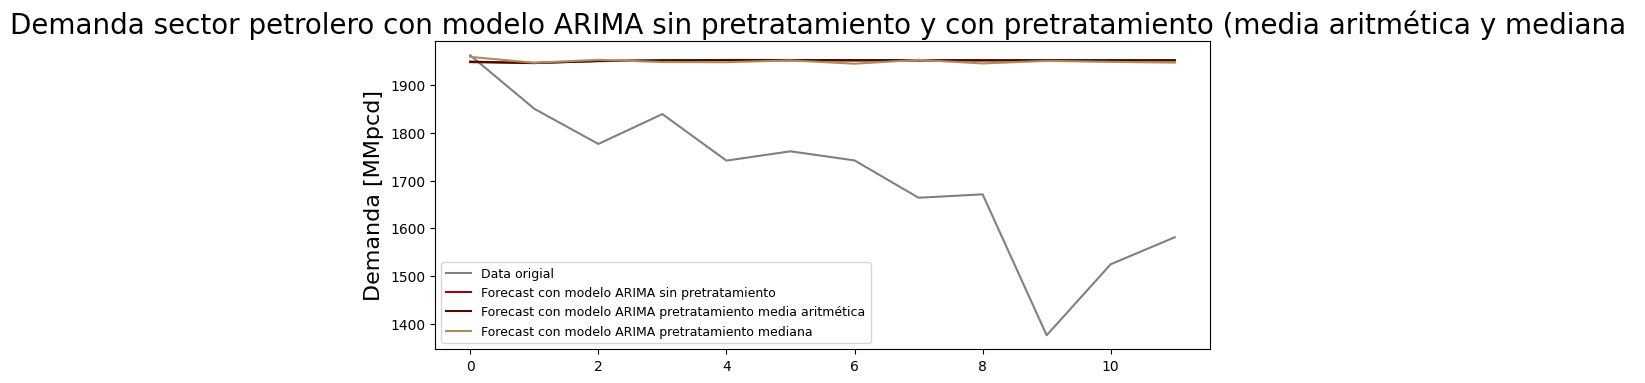

In [111]:
##Ploting the predicitons vs the test_data
plt.figure(figsize =(10,4))
plt.plot(demanda_petrolero_original_test_data['Demanded_Gas'].values, color='gray')


plt.plot(predictions_model_ARIMA_petrolero_original.values, color='#92071C')
plt.plot(predictions_model_ARIMA_petrolero_tratamiento_media.values,color='#460E01')

plt.plot(predictions_model_ARIMA_petrolero_tratamiento_mediana.values, color='#AD8C59')



plt.legend(('Data', 'Predictions'), fontsize=16)

plt.legend(('Data origial','Forecast con modelo ARIMA sin pretratamiento','Forecast con modelo ARIMA pretratamiento media aritmética', 'Forecast con modelo ARIMA pretratamiento mediana'), fontsize=9)

plt.title('Demanda sector petrolero con modelo ARIMA sin pretratamiento y con pretratamiento (media aritmética y mediana ', fontsize=20)
plt.ylabel('Demanda [MMpcd]', fontsize=16)

Text(0, 0.5, 'Demanda [MMpcd]')

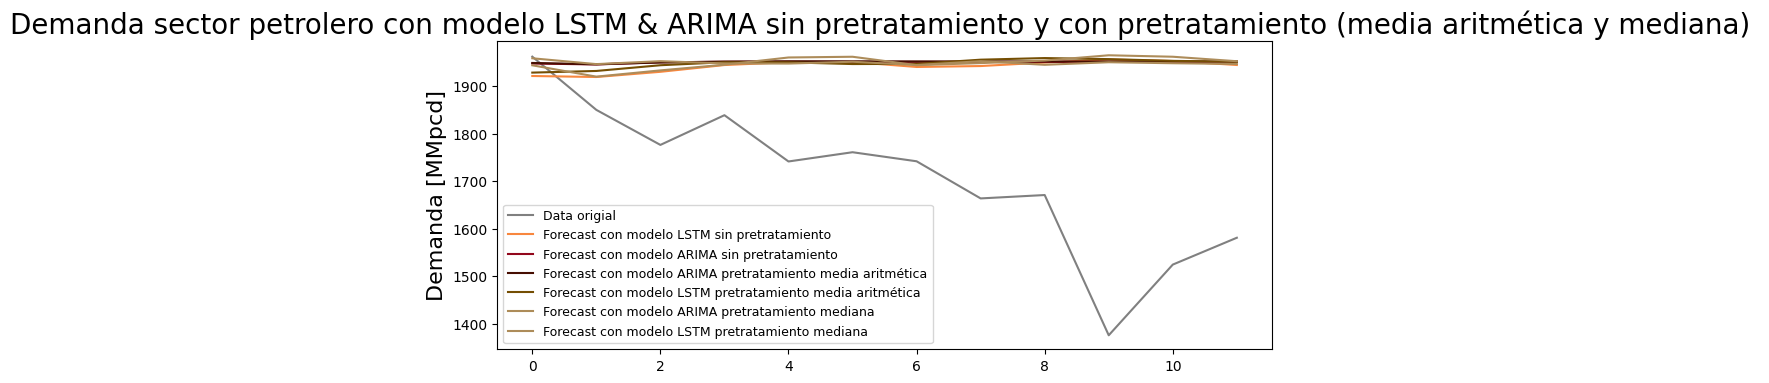

In [113]:
##Ploting the predicitons vs the test_data
plt.figure(figsize =(10,4))
plt.plot(demanda_petrolero_original_test_data['Demanded_Gas'].values, color='gray')

plt.plot(test_predictions_model_LSTM_petrolero_original, color='#F8873E')
plt.plot(predictions_model_ARIMA_petrolero_original.values, color='#92071C')

plt.plot(predictions_model_ARIMA_petrolero_tratamiento_media.values,color='#460E01')
plt.plot(test_predictions_model_LSTM_petrolero_pretratamiento_media , color='#744E03')



plt.plot(predictions_model_ARIMA_petrolero_tratamiento_mediana.values, color='#AD8C59')

plt.plot(test_predictions_model_LSTM_petrolero_pretratamiento_mediana, color='#AD8C5A' )

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.legend(('Data origial', 'Forecast con modelo LSTM sin pretratamiento','Forecast con modelo ARIMA sin pretratamiento', 'Forecast con modelo ARIMA pretratamiento media aritmética' , 'Forecast con modelo LSTM pretratamiento media aritmética ', 'Forecast con modelo ARIMA pretratamiento mediana' , 'Forecast con modelo LSTM pretratamiento mediana'), fontsize=9)

plt.title('Demanda sector petrolero con modelo LSTM & ARIMA sin pretratamiento y con pretratamiento (media aritmética y mediana) ', fontsize=20)
plt.ylabel('Demanda [MMpcd]', fontsize=16)